In [1]:
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import keras

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
CUDA_VISIBLE_DEVICES=0,1,2 

In [3]:
def data2df(dir_path):
    data = list()
    for (root, _, files) in walk(dir_path):
        if '.ipynb_checkpoints' in root:
            continue
        for f in files:
            filepath = join(root, f)
            dirname = root.split('/')[-1] # 取得目錄用於 class name
            data.append([dirname, filepath])
    
    return pd.DataFrame(data, columns=['classname', 'filepath'])

In [4]:
classmap = pd.read_csv('classmap.csv', header=None, index_col=0)

groups = ["1", "2", "3", "4"]  
num = ["0","1", "2", "3"]

dict = {"groups": groups,  
        "num": num
       }

select_df = pd.DataFrame(dict)

classmap= pd.DataFrame(dict)
classmap

,groups,num
0,1,0
1,2,1
2,3,2
3,4,3


In [5]:
classmap.loc[2][1]

'2'

In [6]:
num_classes = 4 #all 4 type dogs
img_size = 224 #set image size

In [7]:
from keras.preprocessing import image
train_dir = 'train/'
total_train_cnt = 0
X = []
y = []

dirs = os.listdir(train_dir)
count=0
for i_dir in range(len(dirs)):
#for i_dir in 1000:  
        count=0;
        dir_name = dirs[i_dir]
        if dir_name =='.ipynb_checkpoints' :
            continue
        files = os.listdir(train_dir + dir_name)
        cnt_train = len(files)
        print(dir_name, ':', cnt_train)
    
    
    
        for i_file in range(cnt_train):
             if(count<=2000):
                count=count+1
         
                if files[i_file].endswith(".jpg"):
                    
                    y.append(classmap.loc[int(dir_name)][1])                   
            
                    img = image.load_img (train_dir + dir_name + '/' + files[i_file],
                                  target_size=(img_size,img_size))
                    img = image.img_to_array(img)
                    X.append(img)
                    total_train_cnt += 1
y = np.asarray(y)
X = np.asarray(X)
print(X.shape)
print(total_train_cnt)

2 : 22990
1 : 23981
0 : 15507
3 : 11979
(8004, 224, 224, 3)
8004


In [8]:
from sklearn.model_selection import train_test_split
y = keras.utils.to_categorical(y, num_classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)
print(X_train.shape)
print(X_val.shape)

(7203, 224, 224, 3)
(801, 224, 224, 3)


In [9]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


#NUM_EPOCHS = 40
#BATCH_SIZE = 64
NUM_EPOCHS =40
BATCH_SIZE = 16

In [10]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow(X_train, y_train,
                                  shuffle=True,
                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow(X_val, y_val,
                                  shuffle=False,
                                  batch_size=BATCH_SIZE)

In [11]:
# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

FREEZE_LAYERS = 2

net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(img_size,img_size,3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
#x = Dropout(0.5)(x)
x = Dropout(0.1)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
 #print(net_final.summary())

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# reduce lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-7)

# 訓練模型
model_history = net_final.fit_generator(train_batches,
                        steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = X_val.shape[0] // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[earlystop, reduce_lr])

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/40
450/450 [==============================] - 83s 184ms/step - loss: 1.0482 - acc: 0.5473 - val_loss: 0.5549 - val_acc: 0.7863
Epoch 2/40
450/450 [==============================] - 64s 143ms/step - loss: 0.5169 - acc: 0.8040 - val_loss: 0.3144 - val_acc: 0.8725
Epoch 3/40
450/450 [==============================] - 64s 143ms/step - loss: 0.3630 - acc: 0.8661 - val_loss: 0.2196 - val_acc: 0.9150
Epoch 4/40
450/450 [==============================] - 64s 143ms/step - loss: 0.2807 - acc: 0.8989 - val_loss: 0.1819 - val_acc: 0.9237
Epoch 5/40
450/450 [==============================] - 64s 143ms/step - loss: 0.2380 - acc: 0.9154 - val_loss: 0.1973 - val_acc: 0.9213
Epoch 6/40
450/450 [==============================] - 64s 143ms/step - loss: 0.1951 - acc: 0.9318 - val_loss: 0.1243 - val_acc: 0.9513
Epoch 7/40
450/450 [==============================] - 64s 143ms/step - loss: 0.1590 - acc: 0.9425 - val_loss: 0.1440 - val_acc: 0.9437
Epoch 8/40
450/450 [==============================] - 6

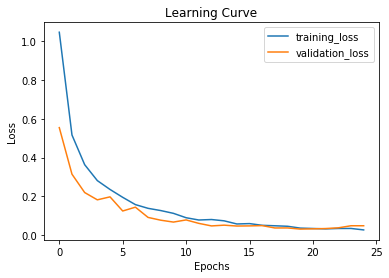

In [12]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()